In [1]:
import numpy as np
import pandas as pd
import scanpy as sc

In [2]:
sc.settings.verbosity = 0             # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_header()
sc.settings.set_figure_params(dpi=80, facecolor='white')

/home/user/lucas-dev/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


scanpy==1.9.6 anndata==0.10.3 umap==0.5.4 numpy==1.26.1 scipy==1.11.3 pandas==1.5.3 scikit-learn==1.3.2 statsmodels==0.14.0 pynndescent==0.5.10


## 0. Reading data into AnnData object

Since we are working with the PBMC-3k dataset and the data is encoded in .mtx format, we use `.read_10x_mtx` to read the data and load it to a AnnData object. The function asks for the path of the folder containing the .mtx file (not the path of the file) and the names we want to use for the genes (variables). By default it uses symbols but we can also call it with 'gene_ids'.

In [3]:
data_path = '../data/external/pbmc3k/'  # the directory with the `.mtx` file
results_file = 'write/pbmc3k.h5ad'      # the file that will store the analysis results

adata = sc.read_10x_mtx(
    path = data_path,            # the directory with the `.mtx` file
    var_names = 'gene_symbols',  # use gene symbols for the variable names (variables-axis index)
    cache = True)    

/home/user/lucas-dev/lib/python3.10/site-packages/anndata/__init__.py:51: FutureWarning: `anndata.read` is deprecated, use `anndata.read_h5ad` instead. `ad.read` will be removed in mid 2024.
  warnings.warn(


By calling the AnnData object we can see that we have 2700 cells (observations) and 32738 genes (variables). In this case all the variables have a unique name (identifier) but in case that we get a warning, we can call `.var_names_make_unique()` to make all the variables names unique.

In [4]:
adata

AnnData object with n_obs × n_vars = 2700 × 32738
    var: 'gene_ids'

Names of cells and genes can be accesed by calling `.obs_names` and `.var_names` respectively.

## 1. Preprocessing

One of the previous steps before analysing the data is to treat it so that the statisticals computations make more sense. In this case, we know that scRNA-seaquencing suffers from the so called 'curse of dimensionalty'. Even though we tend to think that the more features (genes) the best to classify the observations, it is not always true. This often happens in this field where the number of variables is too high, so that there are many of them that don't actually add information, but rather noise.

/home/user/lucas-dev/lib/python3.10/site-packages/seaborn/categorical.py:82: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  plot_data = [np.asarray(s, float) for k, s in iter_data]


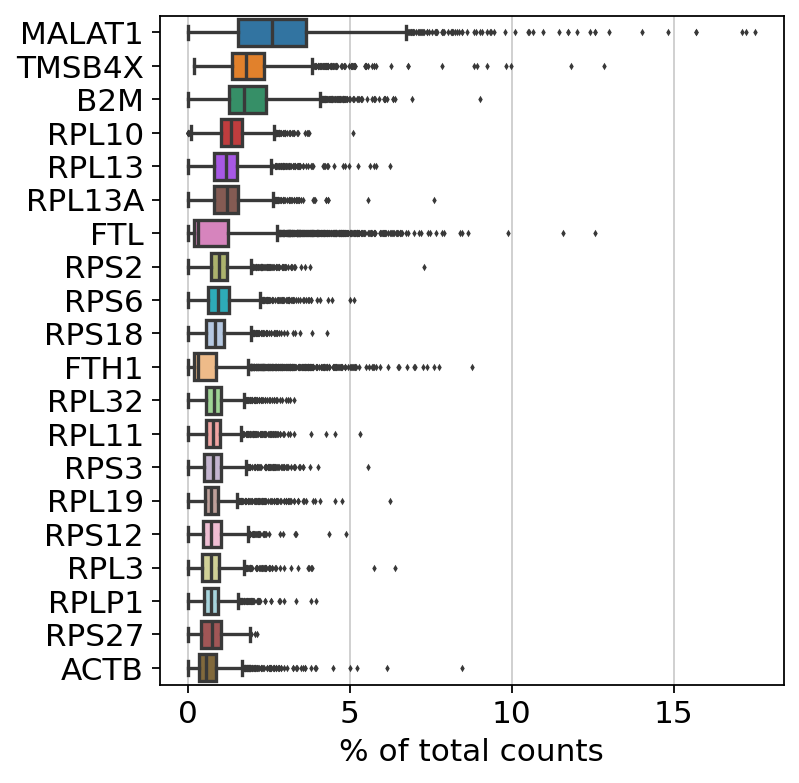

In [5]:
sc.pl.highest_expr_genes(adata, n_top=20,)

We can see that the representation of the genes varies a lot. That is why we can process the data and keep only the cells or genes that verify certain conditions. For instance, we can acees all the pre-processing functions by calling `.pp`. For example, we can filter both cells and genes separately using `.filter_cells` and `.filter_genes`. The changes are made inplace by default, so that the AnnData will be changed directly. In order to keep the original data intacted, we can make a copy and modify this copy. This can be done with `.copy()` and its a tool we will be using along.

In [6]:
adata1 = adata.copy()

In [7]:
sc.pp.filter_cells(adata1, min_genes=200)
sc.pp.filter_genes(adata1, min_cells=3)

We can see that when we call the AnnData object again, it has less variables than before. This means that the `.filter_cells` didn't do anything (all cells have more gens expressed than 200) whereas the `.filter_genes` left out a lot of genes expressed only in 2 cells maximum.

In [8]:
adata1

AnnData object with n_obs × n_vars = 2700 × 13714
    obs: 'n_genes'
    var: 'gene_ids', 'n_cells'

### 1.1. Quality Control

One can also perform easy quality control metrics all at once, for both the cells and genes. This is done using the `.pp.calculate_qc_metrics` inside the pre-processing module. If we call it just with the AnnData object inplace, some features will be added to both `.obs` and `.var`.

In [9]:
adata2 = adata.copy()
sc.pp.calculate_qc_metrics(adata2, percent_top=None, log1p=False, inplace=True)

In [10]:
adata2

AnnData object with n_obs × n_vars = 2700 × 32738
    obs: 'n_genes_by_counts', 'total_counts'
    var: 'gene_ids', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'

I will briefly talk about the different features added. All of them can be calculated by hand using the original data.

**Observations:**
1. `n_genes_by_counts`:  The number of genes with at least 1 count in a cell. Calculated for all cells.
2. `total_counts`: Total number of counts for a cell. (Each gene can be expressed more than once in a cell).

**Variables:**
1. `n_cells_by_counts`: Number of cells this expression is measured in. In general there will be a lot of genes which are not expressed in any cell. That is why, by doing a previous filter over the data we can reduce the data by keeping those genes that are expressed in at least three cell (for example).
2. `mean_counts`: Mean expression over all cells.
3. `total_counts`: Sum of counts for a gene. (One gene can be expressed more than once in each cell).



In [11]:
adata2.obs.head()

,n_genes_by_counts,total_counts
AAACATACAACCAC-1,781,2421.0
AAACATTGAGCTAC-1,1352,4903.0
AAACATTGATCAGC-1,1131,3149.0
AAACCGTGCTTCCG-1,960,2639.0
AAACCGTGTATGCG-1,522,981.0


For example, taking a look at `.obs` we can obtain the `n_genes_by_counts` and `total_counts` of a particular cell by doing `np.count_nonzero(adata[{cell_id}, :].X.toarray())` and `np.sum(adata[{cell_id}, :].X.toarray())`.

In [12]:
cell_id = 'AAACATACAACCAC-1'
genes = np.count_nonzero(adata2[cell_id, :].X.toarray())
total = np.sum(adata2[cell_id, :].X.toarray())
print(f'genes: {genes}', f'\ntotal: {total}')

genes: 781 
total: 2421.0


As was said before, in the original dataframe there are many genes that are not expressed, and so when calling `.var` we see many zeros. Instead, we can do the same but previously applying a filter to the variables like we did to `adata1`:

In [13]:
adata2.var.head()

,gene_ids,n_cells_by_counts,mean_counts,pct_dropout_by_counts,total_counts
MIR1302-10,ENSG00000243485,0,0.0,100.0,0.0
FAM138A,ENSG00000237613,0,0.0,100.0,0.0
OR4F5,ENSG00000186092,0,0.0,100.0,0.0
RP11-34P13.7,ENSG00000238009,0,0.0,100.0,0.0
RP11-34P13.8,ENSG00000239945,0,0.0,100.0,0.0


In [49]:
adata3 = adata1.copy()
sc.pp.calculate_qc_metrics(adata3, percent_top=None, log1p=False, inplace=True)

In [50]:
adata3.var.head()

,gene_ids,n_cells,n_cells_by_counts,mean_counts,pct_dropout_by_counts,total_counts
AL627309.1,ENSG00000237683,9,9,0.003333,99.666667,9.0
AP006222.2,ENSG00000228463,3,3,0.001111,99.888889,3.0
RP11-206L10.2,ENSG00000228327,5,5,0.001852,99.814815,5.0
RP11-206L10.9,ENSG00000237491,3,3,0.001111,99.888889,3.0
LINC00115,ENSG00000225880,18,18,0.006667,99.333333,18.0


### 1.2. Normalization

In [16]:
normalized = sc.pp.normalize_total(adata3, target_sum=None, inplace=False)
adata3.layers["log1p_norm"] = sc.pp.log1p(normalized['X'], copy=True)

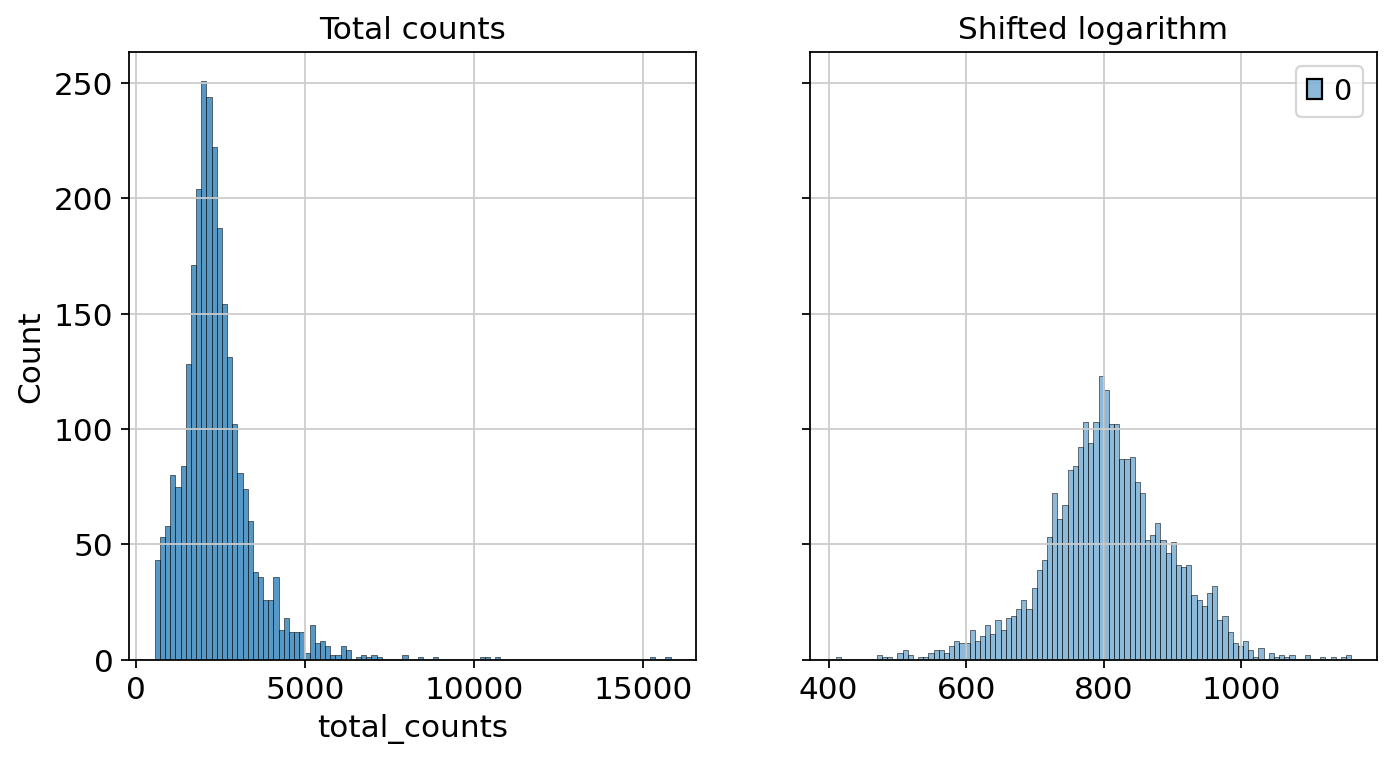

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, axes = plt.subplots(nrows=1, ncols=2, sharey=True, figsize=(10, 5))
p1 = sns.histplot(adata3.obs["total_counts"], bins=100, kde=False, ax=axes[0])
axes[0].set_title("Total counts")
p2 = sns.histplot(adata3.layers["log1p_norm"].sum(1), bins=100, kde=False, ax=axes[1])
axes[1].set_title("Shifted logarithm")
plt.show()

### 1.3. Dimensionality reduction

There are different methods in `scanpy` that can be used to reduced the dimension of the data. In particular we will cover the top three used: Principal Component Analysis (PCA), t-distributed Stochastic Neighbor Embedding (t-SNE) and Uniform Manifold Approximation and Projection (UMAP).

#### 1.3.1. PCA

PCA creates a new set of uncorrelated variables, so called principle components (PCs), via an orthogonal transformation of the original dataset. The PCs are linear combinations of features in the original dataset and are ranked with decreasing order of variance to define the transformation. Through the ranking usually the first PC amounts to the largest possible variance. PCs with the lowest variance are discarded to effectively reduce the dimensionality of the data without losing information.

In order to apply it to our data, first we need to perform the method via `.tl.pap` or `.pp.pca` (they are actually the same function) and then scatter plot it using `.pl.pca`. To plot it we only need to pass the AnnData object since it will look for the components saved in `uns`, `obsm` and `varm`. In case we want the scatter plot to be colored, we can add which variable to take into account (or cell/gene).

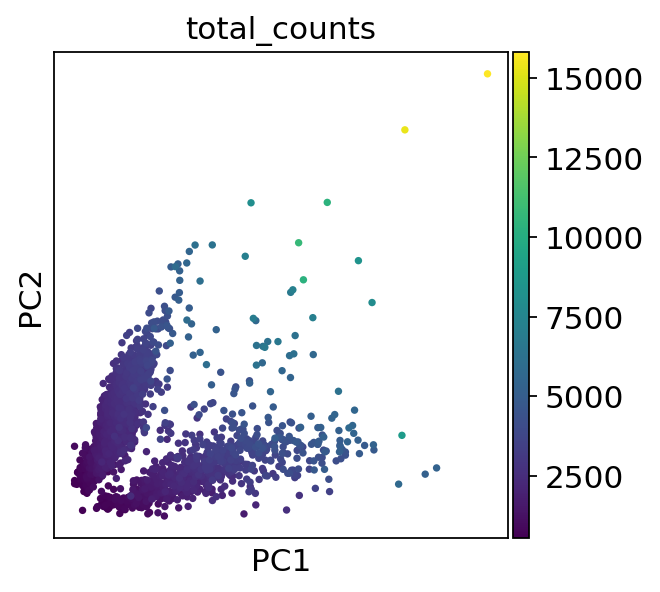

In [52]:
sc.tl.pca(adata3, svd_solver='arpack')
sc.pl.pca(adata3, color='total_counts')

#### 1.3.2. t-SNE

Is a graph based, non-linear dimensionality reduction technique which projects the high dimensional data onto 2D or 3D components. The method defines a Gaussian probability distribution based on the high-dimensional Euclidean distances between data points. Subsequently, a Student t-distribution is used to recreate the probability distribution in a low dimensional space where the embeddings are optimized using gradient descent.

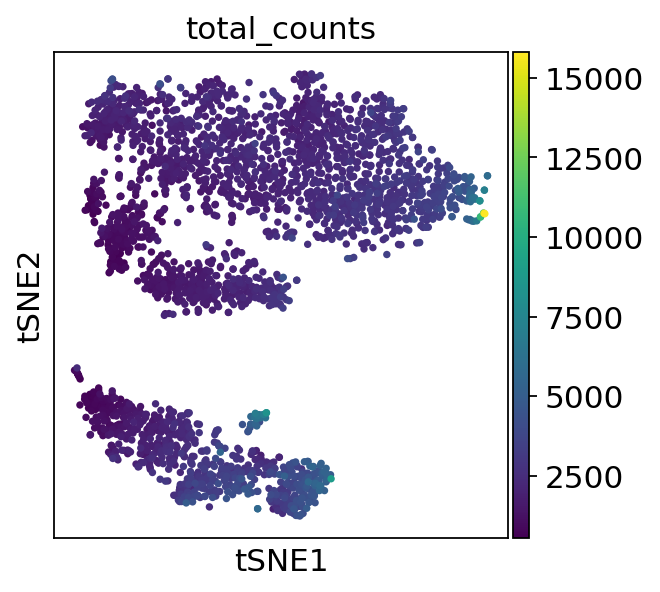

In [27]:
sc.tl.tsne(adata3, use_rep="X_pca")
sc.pl.tsne(adata3, color="total_counts")

#### 1.3.3. UMAP

UMAP is a graph based, non-linear dimensionality reduction technique and principally similar to t-SNE. It constructs a high dimensional graph representation of the dataset and optimizes the low-dimensional graph representation to be structurally as similar as possible to the original graph.

We first calculate PCA and subsequently a neighborhood graph on our data.

/home/user/lucas-dev/lib/python3.10/site-packages/numba/np/ufunc/parallel.py:371: NumbaWarning: The TBB threading layer requires TBB version 2021 update 6 or later i.e., TBB_INTERFACE_VERSION >= 12060. Found TBB_INTERFACE_VERSION = 12050. The TBB threading layer is disabled.
  warnings.warn(problem)


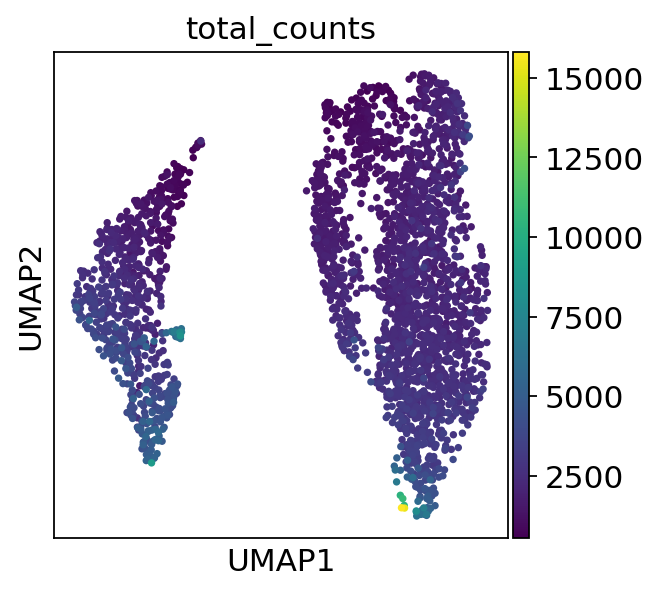

In [22]:
sc.pp.neighbors(adata3)
sc.tl.umap(adata3)
sc.pl.umap(adata3, color="total_counts")

### 1.4. Clustering

Once one has performed the reduciton of dimension to the data, we can actually visulize it in a 2D or 3D graph. Then, clustering mehtods can be applied to this reduced data in order to group the principal components. To do so, we can use different clustering mehtods available in the `scanpy` module. Here we will show two of them, which make use of a graph structure on the data.

That is why we will need first to calculate the KNN graph on the lower-dimentional data using the `.pp.neighbors`. Appart from the data, we also need to provide the number of principal components we want to use (how many dimensions out of the total ones we want to keep). This is an important choice and it will depend on the percentage of information that each principal component carries. We can see this using the `.pl.pca_variance_ratio` function over the data.

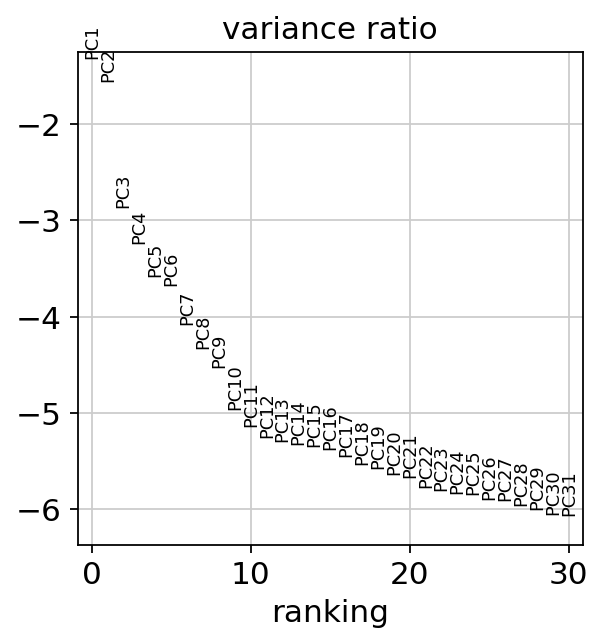

In [53]:
sc.pl.pca_variance_ratio(adata3, log=True)

In this case, we can see that the first two principal components carry a lot of information, and from the third one and so on, the percentace decays. Choosing only two or three coponents to reduce all the genes features is too much, but taking the first ten (in this case) can work quite well. In the plots below we compare the clusters performs to both the reduced data with two and ten principal components.

A good practice in order to have all the data organized, is to pass the `key_added` so that each KNN graph is stored in a different variable: neighbors data in `.uns[key_added]`, distances are stored in `.obsp[key_added+’_distances’]` and connectivities in `.obsp[key_added+’_connectivities’]`.

In [55]:
sc.pp.neighbors(adata3, n_pcs=2, key_added='neighbors2')
sc.pp.neighbors(adata3, n_pcs=10, key_added='neighbors10')

In [57]:
adata3

AnnData object with n_obs × n_vars = 2700 × 13714
    obs: 'n_genes', 'n_genes_by_counts', 'total_counts'
    var: 'gene_ids', 'n_cells', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'
    uns: 'pca', 'neighbors2', 'neighbors10'
    obsm: 'X_pca'
    varm: 'PCs'
    obsp: 'neighbors2_distances', 'neighbors2_connectivities', 'neighbors10_distances', 'neighbors10_connectivities'

#### 1.4.1. Leiden algorithm

We can perform this algorithm using the `.tl.leiden` function and by passing the reduced data with the KNN graph already performed and the resolution parameter (1 by default) which quantifies (in a way) the number of clusters. We can also pass the `neighbors_key` in case we have performed multiple KNN graphs and the `key_added` is case we use different resolutions parameters to compare them.

In [58]:
sc.tl.leiden(adata3, key_added='leiden2', neighbors_key='neighbors2')
sc.tl.leiden(adata3, key_added='leiden10', neighbors_key='neighbors10')

/home/user/lucas-dev/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/user/lucas-dev/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


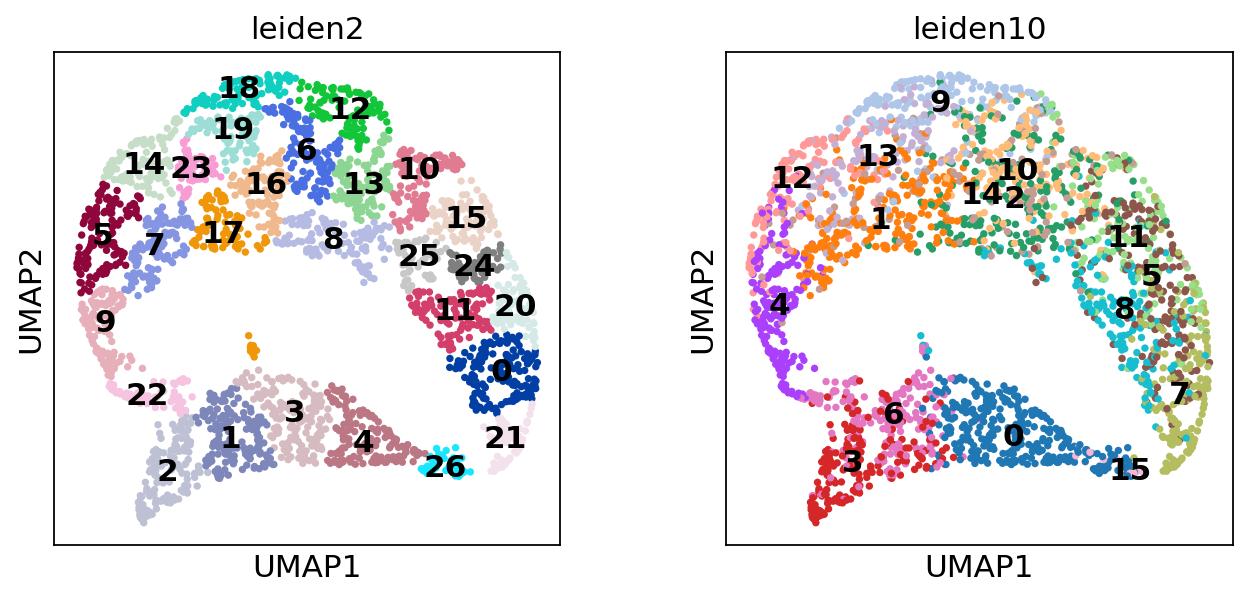

In [61]:
sc.tl.umap(adata3, neighbors_key='neighbors2')

sc.pl.umap(
    adata3,
    color=["leiden2", "leiden10"],
    legend_loc="on data",
)

/home/user/lucas-dev/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/user/lucas-dev/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


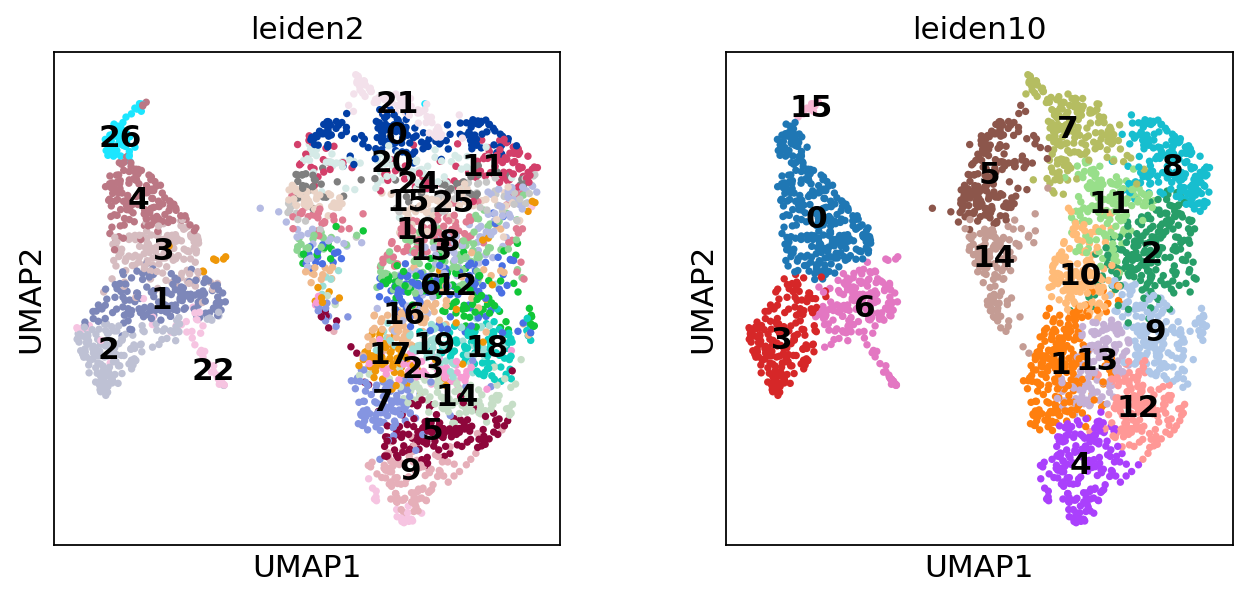

In [62]:
sc.tl.umap(adata3, neighbors_key='neighbors10')

sc.pl.umap(
    adata3,
    color=["leiden2", "leiden10"],
    legend_loc="on data",
)

#### 1.4.1. Leiden algorithm